# Competitor Product Benchmarking + Tagging Tool


### Overview
In the highly competitive world of e-commerce and retail, understanding how your products compare to competitors is crucial for pricing strategy, customer retention, and overall market positioning. To address this, a Competitor Price Benchmarker is the solution, a lightweight yet powerful tool that helps product owners quickly assess how their offerings stack up against the competition.

### What it Does
This tool allows a product owner to input their product details, such as title, price, and rating. The it compares them with competitor listings. The system performs a side-by-side analysis and computes a combined similarity score based on:

1. Title Similarity (via fuzzy matching)

2. Rating Difference

3. Price Difference

This score helps determine how closely a competitor’s product aligns with yours, both in terms of content and market positioning.

In addition to providing a score, the system will include a Tag feature. When an item has a summary, description, or any text describing it, a pre-trained classification model will automatically assign a relevant Tag from a predefined set of categories.

The goal of this feature is to offer a clear, concise label that helps users quickly understand the nature of the item based on its text content.


In [17]:
!pip install selenium

In [18]:
!pip install rapidfuzz

In [19]:
!pip install fake-useragent

In [20]:
!pip install undetected-chromedriver

In [21]:
# import the libraries needed

import re
import hashlib
import random
import numpy as np
import pandas as pd
import selenium
import requests
from flask import Flask, request, jsonify
from fake_useragent import UserAgent
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import undetected_chromedriver as uc
from rapidfuzz import process, fuzz
import time
import json

In [22]:
print(selenium.__version__)

4.34.2


In [23]:
!apt update && apt install -y chromium-chromedriver

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
35 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [24]:
!which chromedriver

/usr/bin/chromedriver


In this note book, the website that will be scrapped is https://books.toscrape.com/ which is a famous website for testing web scrapers.

The website has 50 pages in which each page contains 20 books. Each book will scraped and the contents will be saved for further uses.

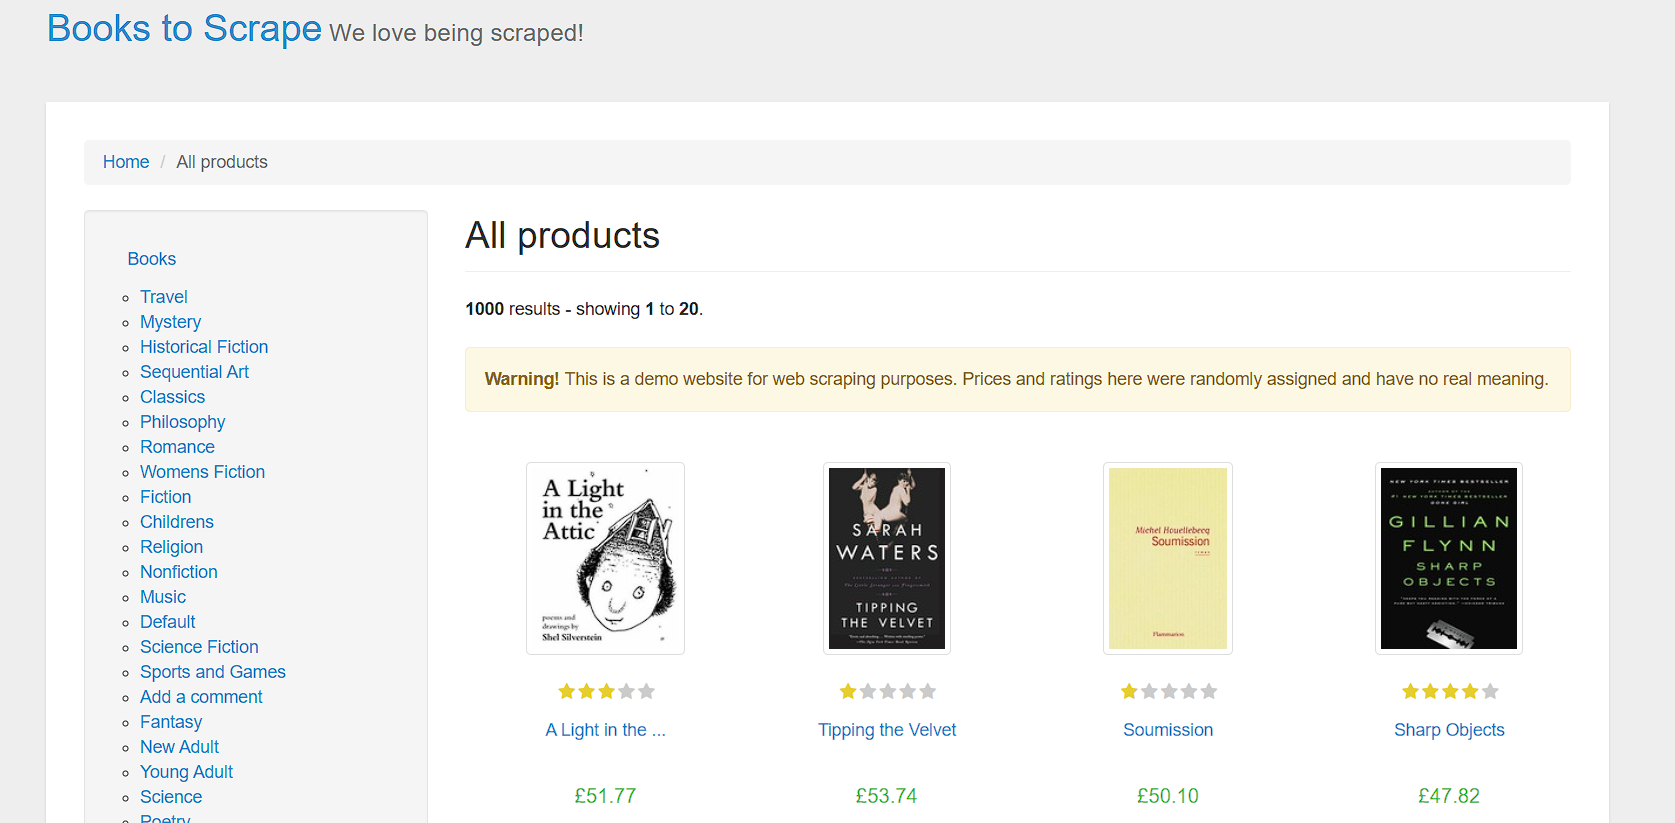

In [25]:
import os
os.environ['PATH'] += ':/usr/lib/chromium-browser/'

In [26]:
# user agents using the UserAgent library
userAgents = UserAgent()

This code sets up a headless Chrome WebDriver with custom options for automated web browsing. It includes:

1. A random user-agent to simulate different browsers and avoid detection.

2. An optional proxy server for routing traffic.

3. Headless mode, meaning the browser runs without a UI (useful for servers or automation).

4. Performance and security flags like --disable-gpu and --no-sandbox.

Selenium is used because it mimics human interactions with web pages, such as clicking, scrolling, and waiting for dynamic content making it ideal for scraping data from JavaScript heavy sites or performing full end-to-end testing. It enables automation where static requests fall short.

In [27]:
# setup the headless header

user_agent = userAgents.random
chrome_options = Options()
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=chrome_options)

In [28]:
driver = webdriver.Chrome(options=chrome_options)
driver.get("https://books.toscrape.com/")

if "captcha" in driver.page_source.lower():
    print("CAPTCHA detected. You need to solve it.")

time.sleep(2)

For cases where the website uses CAPTCHA, possible solutions to this problem is to use 2Captcha and other captcha solver services

In [29]:
# for captcha handling - use CaptchaSolvers like 2Captcha

# example code for it
def captcha():
  API_KEY = 'YOUR_2CAPTCHA_API_KEY'
  site_key = 'SITE_KEY_FROM_PAGE'
  url = driver.current_url

  response = requests.get(
      f"http://2captcha.com/in.php?key={API_KEY}&method=userrecaptcha&googlekey={site_key}&pageurl={url}"
  )
  captcha_id = response.text.split('|')[1]

  while True:
      res = requests.get(f"http://2captcha.com/res.php?key={API_KEY}&action=get&id={captcha_id}")
      if 'OK|' in res.text:
          break
      time.sleep(5)

  captcha_code = res.text.split('|')[1]
  driver.execute_script(f"document.getElementById('g-recaptcha-response').innerHTML = '{captcha_code}';")

In [30]:
# store the data
all_books = []
i=0

Takes all the data from the website needed and saves it into an array

In [31]:
while True:
    books = driver.find_elements(By.CSS_SELECTOR, "article.product_pod")
    for book in books:
        title_element = book.find_element(By.CSS_SELECTOR, "h3 a")
        title = title_element.get_attribute("title")
        relative_url = title_element.get_attribute("href")
        price = book.find_element(By.CSS_SELECTOR, ".price_color").text
        availability = book.find_element(By.CSS_SELECTOR, ".availability").text.strip()
        rating = book.find_element(By.CSS_SELECTOR, "p.star-rating").get_attribute("class").split()[-1]

        all_books.append({
            "id":i,
            "Title": title,
            "Price": price,
            "Availability": availability,
            "Rating": rating,
            "url": relative_url
        })
        i+=1

    # Try to go to next page
    try:
        next_btn = driver.find_element(By.CSS_SELECTOR, "li.next a")
        next_page = next_btn.get_attribute("href")
        driver.get(next_page)
        time.sleep(1)
    except:
        break  # No more pages

driver.quit()

In [38]:
df_books = pd.DataFrame(all_books)
df_books.head(10)

,id,Title,Price,Availability,Rating,url
0,0,A Light in the Attic,£51.77,In stock,Three,https://books.toscrape.com/catalogue/a-light-i...
1,1,Tipping the Velvet,£53.74,In stock,One,https://books.toscrape.com/catalogue/tipping-t...
2,2,Soumission,£50.10,In stock,One,https://books.toscrape.com/catalogue/soumissio...
3,3,Sharp Objects,£47.82,In stock,Four,https://books.toscrape.com/catalogue/sharp-obj...
4,4,Sapiens: A Brief History of Humankind,£54.23,In stock,Five,https://books.toscrape.com/catalogue/sapiens-a...
5,5,The Requiem Red,£22.65,In stock,One,https://books.toscrape.com/catalogue/the-requi...
6,6,The Dirty Little Secrets of Getting Your Dream...,£33.34,In stock,Four,https://books.toscrape.com/catalogue/the-dirty...
7,7,The Coming Woman: A Novel Based on the Life of...,£17.93,In stock,Three,https://books.toscrape.com/catalogue/the-comin...
8,8,The Boys in the Boat: Nine Americans and Their...,£22.60,In stock,Four,https://books.toscrape.com/catalogue/the-boys-...
9,9,The Black Maria,£52.15,In stock,One,https://books.toscrape.com/catalogue/the-black...


As seen from the table above, some columns need readjusting before doing any analysis. Price needs to be changed into an interger with the pounds symbol (british pounds) to be removed. Ratings can also be changed from a string representation (Five) into an integer (5).

In [39]:
# change data types
df_books['Price'] = (df_books['Price'].str.replace('£', '', regex=False).astype(float))



rating_map = {
      "One": 1,
      "Two": 2,
      "Three": 3,
      "Four": 4,
      "Five": 5,
      "Six": 6,
      "Seven": 7,
      "Eight": 8,
      "Nine": 9,
      "Ten": 10
  }
df_books['Rating'] = df_books['Rating'].map(rating_map)

df_books

,id,Title,Price,Availability,Rating,url
0,0,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...
1,1,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...
2,2,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...
3,3,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...
4,4,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...
...,...,...,...,...,...,...
995,995,Alice in Wonderland (Alice's Adventures in Won...,55.53,In stock,1,https://books.toscrape.com/catalogue/alice-in-...
996,996,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,In stock,4,https://books.toscrape.com/catalogue/ajin-demi...
997,997,A Spy's Devotion (The Regency Spies of London #1),16.97,In stock,5,https://books.toscrape.com/catalogue/a-spys-de...
998,998,1st to Die (Women's Murder Club #1),53.98,In stock,1,https://books.toscrape.com/catalogue/1st-to-di...


Next is to create an example, where 1 own product and 1 competitor product wil be taken from the dataset above

In [61]:
# for example my product is 'A Light in the Attic'

our_products = df_books[df_books['Title'].isin(['A Light in the Attic'])]
our_products = [
    {
        "title": row['Title'],
        "price": row['Price'],
        "availability": row['Availability'],
        "rating": row['Rating']
    }
    for _, row in our_products.iterrows()
]

# and my competitor/book = Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)
comp_products = df_books[df_books['Title'].isin(['Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)'])]
comp_products =  [
    {
        "title": row['Title'],
        "price": row['Price'],
        "availability": row['Availability'],
        "rating": row['Rating']
    }
    for _, row in comp_products.iterrows()
]

The function to measure how the score between both items, where ratings, price, and the title will be taken into consideration. The score that is calculated is to quantify how **similar** a competitor product is to the user's product.

The score will be calculated based on this equation :    
- 60% on the title.
- 20% on the ratings.
- 20% on the price.

Title is weighted most heavily (0.6) because it’s the most distinctive identifier. Rating and Price matter but to a lesser extent (0.2 each), because products might be priced or rated differently even if they are otherwise similar.


In [66]:
def match_product(my_product, competitor_products, title_weight=0.6, rating_weight=0.2, price_weight=0.2):
    for comp in competitor_products:
        title_score = fuzz.token_sort_ratio(my_product["title"], comp["title"]) / 100
        rating_diff = abs(my_product["rating"] - comp["rating"])
        rating_score = max(0, 1 - (rating_diff / 5))
        price_diff_pct = abs(my_product["price"] - comp["price"]) / max(comp["price"], 1e-3)
        price_score = max(0, 1 - price_diff_pct)

        combined_score = (
            title_weight * title_score +
            rating_weight * rating_score +
            price_weight * price_score
        )

    return round(combined_score * 100, 2), comp

In [68]:
results = []

for prod in our_products:
    score, comp = match_product(prod, comp_products)
    diff = prod["price"] - comp["price"]
    pct = diff / comp["price"] * 100

    results.append({
        "My Title": prod["title"],
        "My Price": prod["price"],
        "My Rating": prod["rating"],
        "Competitor Title": comp["title"],
        "Competitor Price": comp["price"],
        "Competitor Rating": comp["rating"],
        "Rating Difference": [prod["rating"] - comp["rating"]],
        "Price Diff": round(diff, 2),
        "Diff (%)": round(pct, 2),
        "Match Score": score
    })

df_resul = pd.DataFrame(results)
df_resul

,My Title,My Price,My Rating,Competitor Title,Competitor Price,Competitor Rating,Rating Difference,Price Diff,Diff (%),Match Score
0,A Light in the Attic,51.77,3,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,4,[-1],-5.29,-9.27,53.56


The results can be stored in a JSON format, which is ideal for future upgrades, especially when integrating with APIs, since it provides a structured, lightweight, and widely supported way to exchange information between systems.

In [69]:
# return this information as json
resul = [
    {
        "My Title": row['My Title'],
        "My Price": row['My Price'],
        "My Rating": row['My Rating'],
        "Competitor Title": row['Competitor Title'],
        "Competitor Price": row['Competitor Price'],
        "Competitor Rating": row['Competitor Rating'],
        "Rating Difference": row['Rating Difference'],
        "Price Diff": row['Price Diff'],
        "Diff (%)": row['Diff (%)'],
        "Match Score": row['Match Score']
    }
    for _, row in df_resul.iterrows()
]

print(json.dumps(resul, indent=2))

[
  {
    "My Title": "A Light in the Attic",
    "My Price": 51.77,
    "My Rating": 3,
    "Competitor Title": "Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",
    "Competitor Price": 57.06,
    "Competitor Rating": 4,
    "Rating Difference": [
      -1
    ],
    "Price Diff": -5.29,
    "Diff (%)": -9.27,
    "Match Score": 53.56
  }
]


To extract the summary, the system first reinstates the driver and defines the target URL. Once the page is loaded, the system scrapes the summary content, which is then sent to a pre-trained language model via an API for classification.

The example book being used in this part is : https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html

In [70]:
# recall the driver and extract the summary info
url = "https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html"
driver = webdriver.Chrome(options=chrome_options)
driver.get(url)
time.sleep(2)
description_header = driver.find_element(By.ID, "product_description")
description = description_header.find_element(By.XPATH, "following-sibling::p").text
driver.quit()

In [71]:
# this is the summary extracted

description

"It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20th anniversary with this special edition. Silverstein's humorous and creative verse can amuse the dowdiest of readers. Lemon-faced adults and fidgety kids sit still and read these rhythmic words and laugh and smile and love th It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20th anniversary with this special edition. Silverstein's humorous and creative verse can amuse the dowdiest of readers. Lemon-faced adults and fidgety kids sit still and read these rhythmic words and laugh and smile and love that Silverstein. Need proof of his genius? RockabyeRockabye baby, in the treetopDon't you know a treetopIs no safe place to rock?And who put you up there,And your cradle, too?Baby, I think someone down here'sGot it in for you. Shel, you never sounde

To identify tags based on the summary, first the class of tags must be defined first. The tags being used in this example is :    
1. "Best Seller"
2. "Niche"
3. "General"
4. "Academic"
5. "Indie"

These tags were chosen to cover a broad but meaningful spectrum of how books are typically positioned in the market and consumed by readers.

The next step is to call the API of a pre-trained model. For this task, Hugging Face is chosen due to its ease of access and API integration. In this example, the bert-large-mnli model is used for zero-shot text classification.

The reason this model is selected is it excels at inferring relationships between text segments without requiring task-specific fine-tuning. Since it was trained on the Multi-Genre Natural Language Inference (MNLI) dataset, it can evaluate whether a given sentence logically entails, contradicts, or is neutral toward a set of candidate labels. This makes it particularly well-suited for classifying summaries into user-defined categories like "Best Seller" or "Academic" even if it wasn’t explicitly trained on those labels. The label picked later on will be the label with the highest score.

In [72]:
with open("TOKENS.txt", "r") as f:
    hf_token = f.read().strip()
    os.environ["HF_TOKEN"] = hf_token

API_URL = 'https://router.huggingface.co/hf-inference/models/facebook/bart-large-mnli'
headers = {
    "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

output = query({
    "inputs": description,
    "parameters": {"candidate_labels": ["Best Seller", "Niche", "General", "Academic", "Indie"]},
})
highest = output["labels"][0]

In [73]:
highest # the tag picked

'Niche'

For future upgrades there are several points,
1. Identify a better way to find similarity, example with cosine similarity
2. Define a broader list of class for the model to predict
3. Model can be locally run for better speed and avoiding usage limits (as long as the infrastructure is available)
4. Saving all the summaries of all books locally instead of extracting it everytime (time consuming for the first time)
5. Saving all the data within a SQL database

Features that can be added in the future,
1. Create an analysis of the site, seeing the site's growth and make future predictions.
2. Use a text summarizer to summarize the book's content, price, rating, and etc